In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

2024-06-13 23:28:28.865498: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 23:28:28.869517: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 23:28:28.907504: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 23:28:29.634620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Specify Model
reduced = False
model_type = 'keras' # keras or h5 or onnx
factor_index = 1

# Load Model    

In [27]:
# Load the model
model_url = '../models/fitmotion_model'
if reduced:
    model_url += '_reduced'

if model_type == 'keras':
    model = keras.models.load_model(model_url + '.keras')
elif model_type == 'h5':
    model = tf.keras.models.load_model(model_url + '.h5')
elif model_type == 'onnx':
    import onnx
    import onnxruntime as ort
    sess = ort.InferenceSession(model_url + '.onnx')


labels = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

# Loading The Data

### Native Android Data

In [5]:
# Load Android Data
data_source = 'android_data_latest'
if reduced:
    data_source += '_reduced'
data_type = 'wlk'
data_num = '1'
data_url = '../data/' + data_source + '/' + data_type + '/' + data_type + data_num + '-SensorData.csv'

try:
    df = pd.read_csv(data_url, sep=',')
except:
    df = pd.read_csv(data_url, sep=';')
    
df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
df = df.drop(['id'], axis=1) if 'id' in df.columns else df
df

,id;Attitude Roll;Attitude Pitch;Attitude Azimuth;Gravity X;Gravity Y;Gravity Z;Rotation Rate X;Rotation Rate Y;Rotation Rate Z;User Acceleration X;User Acceleration Y;User Acceleration Z
0,1;0.9115612;1.2327803;-2.8281977;3.159663;-9.2...
1,2;0.9115612;1.2327803;-2.8281977;3.159663;-9.2...
2,3;0.9115612;1.2327803;-2.8281977;3.1540146;-9....
3,4;0.9115612;1.2327803;-2.8281977;3.1540146;-9....
4,5;0.9115612;1.2327803;-2.8281977;3.1540146;-9....
...,...
1528,1529;0.75364864;2.2254827;-2.793956;2.6719775;...
1529,1530;0.75364864;2.2254827;-2.793956;2.6719775;...
1530,1531;0.75364864;2.2254827;-2.793956;2.6719775;...
1531,1532;0.75364864;2.2254827;-2.793956;2.6719775;...


### Web Data

In [29]:
# Load Android Data
data_source = 'html_data'
device_source = 'iphone'
data_type = 'sit'
data_num = '1'
data_url = '../data/' + data_source + '/' + device_source + '/' + data_type + '/' + data_type + '_' + data_num + '.csv'

df = pd.read_csv(data_url, sep=',')
df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
df = df.drop(['id'], axis=1) if 'id' in df.columns else df
df = df.drop(['Timestamp'], axis=1) if 'Timestamp' in df.columns else df
df

,Attitude Roll,Attitude Pitch,Attitude Azimuth,Gravity X,Gravity Y,Gravity Z,Rotation Rate X,Rotation Rate Y,Rotation Rate Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,-156.62,42.47,-156.56,-6.28,-2.72,-6.30,27.36,-3.73,10.39,0.00,0.32,0.60
1,-155.26,42.23,-155.24,-6.45,-2.97,-6.45,33.68,3.85,16.88,-0.16,0.10,0.42
2,-156.21,40.54,-154.74,-6.28,-2.97,-6.72,39.38,-0.37,21.32,0.01,0.15,0.12
3,-156.84,38.12,-153.38,-6.36,-3.19,-7.45,41.00,-22.94,22.07,-0.02,-0.04,-0.67
4,-151.37,37.82,-148.32,-6.70,-4.13,-7.57,40.71,-35.18,26.82,-0.29,-0.95,-0.87
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,-143.71,8.53,-104.23,-1.45,-5.70,-7.76,7.13,-2.73,3.04,-0.06,0.15,-0.02
2097,-140.93,12.03,-108.68,-1.94,-5.75,-7.09,-8.75,5.71,-4.53,-0.57,0.09,0.67
2098,-141.46,9.80,-105.50,-1.68,-6.04,-7.58,-8.00,4.49,-4.09,-0.31,-0.20,0.18
2099,-143.10,8.79,-104.44,-1.52,-5.91,-7.87,-2.13,1.85,-2.40,-0.17,-0.09,-0.10


### Original Data

In [31]:
# Load Orignal Data (for comparison)
data_source_o = 'dataset'
if reduced:
    data_source_o += '_reduced'
data_type_o = 'wlk_7'
data_num_o = '1'
data_url_o = '../data/' + data_source_o + '/' + data_type_o + '/' + 'sub_' + data_num_o + '.csv'

df_o = pd.read_csv(data_url_o)
df_o = df_o.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df_o.columns else df_o
df_o

,gravity.x,gravity.y,gravity.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.139767,0.989987,0.019745,0.091702,0.415881,0.093689
1,-0.152324,0.987759,0.033602,0.367412,0.004566,-0.106082
2,-0.161610,0.985336,0.054729,0.172093,-0.217483,-0.163387
3,-0.168058,0.982470,0.080680,0.004957,-0.237566,-0.019080
4,-0.174613,0.978705,0.107922,-0.040292,-0.241461,0.015201
...,...,...,...,...,...,...
5434,0.268549,0.726621,0.632380,-0.690515,0.160006,-0.301676
5435,0.207323,0.679753,0.703529,-0.628969,0.368785,-0.986305
5436,0.156434,0.649222,0.744338,-0.323685,0.392786,-0.913802
5437,0.128106,0.622337,0.772195,-0.129754,0.223900,-0.717584


In [32]:
# opening scaling factor file to read the dictionary
constants_url = '../constants_reduced.txt' if reduced else '../constants.txt'

factors = []
with open(constants_url, 'r') as f:
    lines = f.readlines()
    for line in lines:
        factors.append(eval(line))
factors

[{'Gravity X': -0.029648750139525837,
  'Gravity Y': -0.2301603051826162,
  'Gravity Z': -0.15008394265004601,
  'User Acceleration X': 0.007038958443613083,
  'User Acceleration Y': 0.005498103809718967,
  'User Acceleration Z': 0.05049859283824429},
 {'Gravity X': -0.0959586547427039,
  'Gravity Y': -0.09569122769633755,
  'Gravity Z': 0.09948208173715353,
  'User Acceleration X': 0.12905120595974687,
  'User Acceleration Y': 0.012367038275536486,
  'User Acceleration Z': 0.048466978127596386}]

In [33]:
# Multiply data with constants
for i in range(len(df.columns)):
    df.iloc[:, i] = df.iloc[:, i] * factors[factor_index][df.columns[i]]

# Preprocessing Data

In [34]:
# Prepare the data
WINDOW_LENGTH = 150
STRIDE_LENGTH = 10
NUM_CLASSES = 6 if reduced else 12
NUM_FEATURES = 12
BATCH_SIZE = 100
EPOCHS_SIZE = 10

In [35]:
from scipy.stats import mode

def sequence_generator(x, length, stride):
    seq_x = []
    data_length = len(x)

    for i in range(0, data_length - length + 1, stride):
        input_sequence = x.iloc[i : i + length]
        seq_x.append(input_sequence)
    return np.array(seq_x)

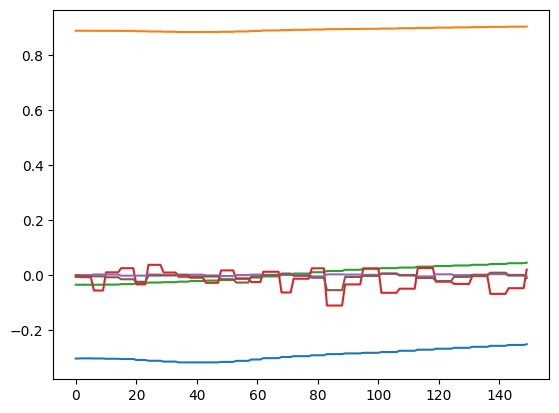

In [36]:
# Checking data
import matplotlib.pyplot as plt

tx = sequence_generator(df, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(tx[0])
plt.show()

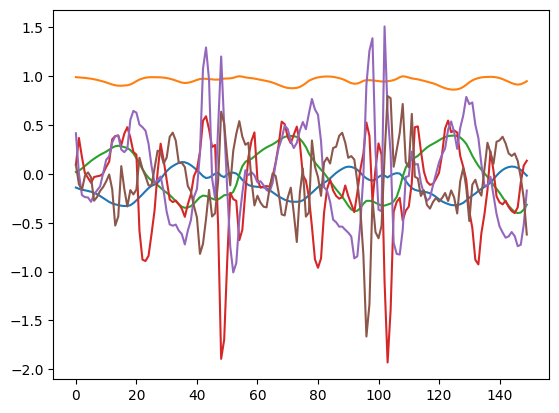

In [37]:
txc = sequence_generator(df_o, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(txc[0])
plt.show()

# Prediction

In [41]:
if model_type == 'onnx':
    # Predict with ONNX
    tx = tx.astype(np.float32)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    y_pred = sess.run([output_name], {input_name: tx})[0]
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]
else: 
    # Predict the data
    y_pred = model.predict(tx)

    # Get the most frequent label
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]

print(labels[y_pred])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
std
